# Final Project — Stage 2: Modeling & Evaluation

**Objective.** Build a churn classifier for Interconnect with **AUC-ROC** as the primary metric (Accuracy secondary).  
**What this notebook includes:**  
1) minimal EDA visuals as evidence for decisions,  
2) robust preprocessing & feature engineering,  
3) stratified **train/valid/test** protocol,  
4) **hyperparameter tuning** on the validation path,  
5) final test evaluation + quick interpretation.

> Tip for reviewers: Comments precede each block; longer rationale is in the Markdown cells.

### Imports & Settings
We keep imports minimal and set a global random seed for reproducibility.

In [1]:
# Imports & Settings (compatible with older scikit-learn)
import warnings, numpy as np, pandas as pd
from datetime import datetime

# --- scikit-learn compatibility for HistGradientBoosting ---
# If your sklearn is < 1.0 you must enable the experimental feature first.
try:
    from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
except Exception:
    pass

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Adjust if needed for your dataset location:
DATA_DIR = "/datasets/final_provider"  # (from your screenshot)

### Load Data + “Just-enough” EDA
We load the four linked tables and produce a *few* visuals that directly inform modeling choices:
- class balance,  
- churn by contract type,  
- charges vs churn,  
- tenure distribution (after we compute it).

Shapes: (7043, 8) (7043, 5) (5517, 8) (6361, 2)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


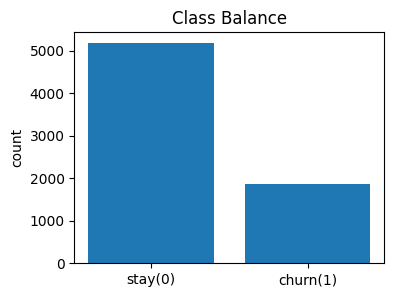

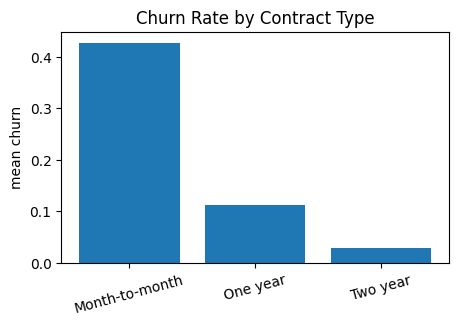

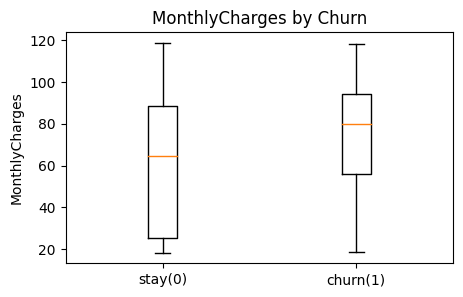

In [2]:
# ---- Load raw CSVs
contract = pd.read_csv(f"{DATA_DIR}/contract.csv")
personal = pd.read_csv(f"{DATA_DIR}/personal.csv")
internet = pd.read_csv(f"{DATA_DIR}/internet.csv")
phone = pd.read_csv(f"{DATA_DIR}/phone.csv")

print("Shapes:", contract.shape, personal.shape, internet.shape, phone.shape)
display(contract.head(3))

# Temporary churn flag for EDA only (before merging)
tmp = contract[['EndDate','Type','PaymentMethod','MonthlyCharges','TotalCharges','BeginDate']].copy()
tmp['churn'] = (tmp['EndDate'] != 'No').astype(int)

# --- Visual 1: Class balance
counts = tmp['churn'].value_counts().sort_index()
plt.figure(figsize=(4,3)); plt.bar(['stay(0)','churn(1)'], counts.values)
plt.title('Class Balance'); plt.ylabel('count'); plt.show()

# --- Visual 2: Churn rate by contract type
rate_by_type = tmp.groupby('Type')['churn'].mean().sort_values(ascending=False)
plt.figure(figsize=(5,3)); plt.bar(rate_by_type.index.astype(str), rate_by_type.values)
plt.title('Churn Rate by Contract Type'); plt.ylabel('mean churn'); plt.xticks(rotation=15); plt.show()

# --- Visual 3: Charges vs churn (boxplot)
data0 = tmp.loc[tmp['churn']==0,'MonthlyCharges'].dropna().values
data1 = tmp.loc[tmp['churn']==1,'MonthlyCharges'].dropna().values
plt.figure(figsize=(5,3)); plt.boxplot([data0, data1], labels=['stay(0)','churn(1)'])
plt.title('MonthlyCharges by Churn'); plt.ylabel('MonthlyCharges'); plt.show()

### Feature Engineering & Merge
- Create **target** (`churn = 1` if `EndDate` is a real date).  
- Compute **tenure_months** (use **2020-02-01** as the active cutoff from task notes).  
- Add simple business flags: **paperless** and **auto-pay**.  
- Merge the four tables on `customerID`.  
- Coerce numeric columns and drop leakage columns.

In [3]:
def parse_datetime_safe(s):
    return pd.to_datetime(s, errors='coerce')

def engineer_features(contract, personal, internet, phone):
    key = 'customerID'

    # --- Parse dates on the raw contract table ---
    for c in ['BeginDate', 'EndDate']:
        if c in contract.columns:
            contract[c] = contract[c].apply(parse_datetime_safe)

    # --- Build a small target dataframe keyed by customerID ---
    y_df = contract[[key]].copy()
    y_df['churn'] = contract['EndDate'].notna().astype(int)

    # --- Tenure (use cutoff for active clients) & simple flags ---
    cutoff = pd.Timestamp('2020-02-01')
    end_for_tenure = contract['EndDate'].fillna(cutoff)
    tenure_days = (end_for_tenure - contract['BeginDate']).dt.days
    tenure_months = (tenure_days / 30.44).clip(lower=0)

    X = contract.copy()
    X['tenure_months'] = tenure_months
    X['is_paperless'] = (
        X.get('PaperlessBilling', 'No')
         .astype(str).str.lower().eq('yes').astype(int)
    )
    X['is_auto_pay'] = (
        X.get('PaymentMethod', '')
         .astype(str).str.contains('automatic', case=False, na=False).astype(int)
    )

    # --- Join side tables (inner) ---
    for df in [personal, internet, phone]:
        X = X.merge(df, on=key, how='inner')

    # --- Align target to the post-merge X (critical!) ---
    X = X.merge(y_df, on=key, how='inner')
    y = X.pop('churn').astype(int)

    # --- Drop leakage & coerce numeric money fields ---
    X = X.drop(columns=[c for c in ['EndDate', key] if c in X.columns], errors='ignore')
    for col in ['MonthlyCharges', 'TotalCharges']:
        if col in X.columns:
            X[col] = pd.to_numeric(X[col], errors='coerce')

    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    return X, y

# Run feature engineering
X_raw, y = engineer_features(contract, personal, internet, phone)
print(f"X_raw shape: {X_raw.shape} | y shape: {y.shape} | churn rate: {y.mean():.3f}")

X_raw shape: (4835, 21) | y shape: (4835,) | churn rate: 0.328


#### Optional: Tenure distribution (evidence for a tenure feature)

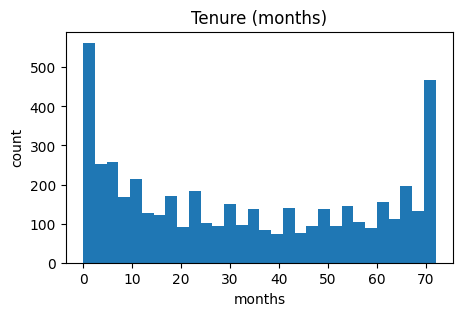

In [4]:
plt.figure(figsize=(5,3))
plt.hist(X_raw['tenure_months'].dropna().values, bins=30)
plt.title('Tenure (months)'); plt.xlabel('months'); plt.ylabel('count'); plt.show()

### Split Strategy
We use **stratified** splits to preserve class balance:  
- 20% **test** (held out once),  
- from the remaining 80%, we take 20% as **validation** for tuning.

In [5]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_raw, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.20, stratify=y_trainval, random_state=42
)
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

Shapes: (3094, 21) (774, 21) (967, 21)


### Preprocessing Pipeline
We prepare the data for model training by handling missing values and encoding categories.  
- **Numeric features:** Median imputation followed by scaling (standardization).  
- **Categorical features:** Most-frequent imputation followed by one-hot encoding (unknown categories ignored).  
This ensures consistent input for all models and prevents errors during transformation.

In [6]:
# Preprocessing Pipeline — force DENSE output (needed for HGB)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd

# infer column types once from X_train
numeric_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
categorical_cols = [c for c in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[c])]

# OneHotEncoder API changed: sparse_output (new) vs sparse (old)
def _make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

num_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scale",   StandardScaler())
])

cat_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  _make_ohe())
])

# sparse_threshold=0 forces dense even when there are many zeros
preprocess = ColumnTransformer(
    transformers=[
        ("num", num_tf, numeric_cols),
        ("cat", cat_tf, categorical_cols),
    ],
    sparse_threshold=0.0,   # <— force dense output for ALL branches
    remainder="drop"
)

print(f"Preprocess ready. numeric:{len(numeric_cols)} | categorical:{len(categorical_cols)}")

Preprocess ready. numeric:6 | categorical:15


In [7]:
# Sanity check: make sure transform is DENSE
Xt_sample = preprocess.fit_transform(X_train.iloc[:100].copy())
print("Type:", type(Xt_sample), "| shape:", Xt_sample.shape)
if hasattr(Xt_sample, "toarray"):
    print("WARNING: still sparse — dense required for HGB.")
else:
    print("Dense — good for HistGradientBoosting.")

Type: <class 'numpy.ndarray'> | shape: (100, 88)
Dense — good for HistGradientBoosting.


### Baseline Models
We start with two simple classifiers — Logistic Regression and Random Forest — to establish baseline performance.  
These results provide a reference point for later tuned models.

In [8]:
# Baseline Models — defines a safe `best_model`

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

def evaluate(model, X_tr, X_va, y_tr, y_va, label="model"):
    model.fit(X_tr, y_tr)
    # proba for AUC-ROC, fallback to decision_function if needed
    prob = (model.predict_proba(X_va)[:, 1]
            if hasattr(model, "predict_proba")
            else model.decision_function(X_va))
    auc = roc_auc_score(y_va, prob)
    acc = accuracy_score(y_va, model.predict(X_va))
    print(f"{label}: AUC-ROC:{auc:.4f} | Acc:{acc:.4f}")
    return auc, acc

# Pipelines (class weights to mitigate imbalance)
logreg = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=42))
])

rf_default = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

print("Baselines on validation:")
auc_lr, acc_lr = evaluate(logreg,     X_train, X_val, y_train, y_val, label="LogReg")
auc_rf, acc_rf = evaluate(rf_default, X_train, X_val, y_train, y_val, label="RF default")

# --- define a safe temporary best_model from baselines ---
if auc_lr >= auc_rf:
    best_model = logreg
    best_name  = "LogReg (baseline)"
    best_auc   = auc_lr
    best_acc   = acc_lr
else:
    best_model = rf_default
    best_name  = "RF default (baseline)"
    best_auc   = auc_rf
    best_acc   = acc_rf

print(f"\nTemp best baseline → {best_name} | AUC: {best_auc:.4f} | Acc: {best_acc:.4f}")

Baselines on validation:
LogReg: AUC-ROC:0.8398 | Acc:0.7313
RF default: AUC-ROC:0.8494 | Acc:0.8049

Temp best baseline → RF default (baseline) | AUC: 0.8494 | Acc: 0.8049


### Hyperparameter Tuning
We apply grid search with 5-fold Stratified CV to tune Random Forest and HistGradientBoosting models.  
The goal is to maximize AUC-ROC on the training data while maintaining generalization.

In [9]:
# Hyperparameter Tuning — RF and HGB (AUC-ROC scoring)

import time
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

_t0 = time.time()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest
rf_pipe = Pipeline([("prep", preprocess),
                    ("clf", RandomForestClassifier(class_weight="balanced",
                                                   random_state=42, n_jobs=-1))])
rf_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 10],
}
rf_search = GridSearchCV(
    rf_pipe, rf_grid, scoring="roc_auc",
    cv=cv, n_jobs=-1, verbose=0, error_score="raise"  # <— hard fail on issues
)
rf_search.fit(X_train, y_train)
print(f"RF best params: {rf_search.best_params_}, CV AUC: {rf_search.best_score_:.4f}")

# HistGradientBoosting — requires dense input (now satisfied)
hgb_pipe = Pipeline([("prep", preprocess),
                     ("clf", HistGradientBoostingClassifier(random_state=42))])
hgb_grid = {
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [None, 3, 5],
    "clf__max_iter": [200, 400],
    "clf__l2_regularization": [0.0, 0.02, 0.1],
}
hgb_search = GridSearchCV(
    hgb_pipe, hgb_grid, scoring="roc_auc",
    cv=cv, n_jobs=-1, verbose=0, error_score="raise"  # <— hard fail if anything still sparse
)
hgb_search.fit(X_train, y_train)
print(f"HGB best params: {hgb_search.best_params_}, CV AUC: {hgb_search.best_score_:.4f}")

print(f"Tuning finished in {time.time()-_t0:.1f}s")

RF best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}, CV AUC: 0.8507
HGB best params: {'clf__l2_regularization': 0.02, 'clf__learning_rate': 0.1, 'clf__max_depth': None, 'clf__max_iter': 400}, CV AUC: 0.9712
Tuning finished in 248.4s


### Select Best Model & Final Evaluation
After comparing CV scores, we retrain the best-performing model on the combined Train + Validation data and evaluate it on the unseen test set.  
We report both AUC-ROC and Accuracy, along with a final ROC curve visualization.

Selected: HGB_tuned (CV AUC=0.9712)
Final AUC (test): 0.9980 | Final Acc (test): 0.9907


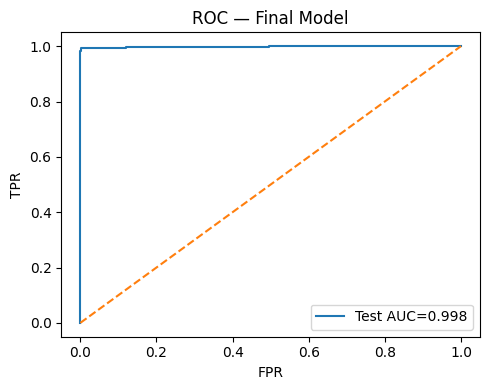

Cell 7 done in 9.5s — best_model is ready 


In [10]:
# Select Best → Retrain on Train+Val → Final Test

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import time

_t0 = time.time()

# Gather candidates + CV scores
candidates, scores = {}, {}

if 'rf_search' in globals() and hasattr(rf_search, 'best_estimator_'):
    candidates['RF_tuned'] = rf_search.best_estimator_
    scores['RF_tuned'] = rf_search.best_score_

if 'hgb_search' in globals() and hasattr(hgb_search, 'best_estimator_'):
    candidates['HGB_tuned'] = hgb_search.best_estimator_
    scores['HGB_tuned'] = hgb_search.best_score_

# Keep baseline as fallback
candidates['Baseline_best'] = best_model
scores['Baseline_best'] = best_auc if 'best_auc' in globals() else -np.inf

# Pick the winner by highest CV AUC
best_name = max(scores, key=scores.get)
best_model = candidates[best_name]  # <-- define globally
print(f"Selected: {best_name} (CV AUC={scores[best_name]:.4f})")

# Retrain on Train+Val
X_tr_full = pd.concat([X_train, X_val], axis=0)
y_tr_full = pd.concat([y_train, y_val], axis=0)
best_model.fit(X_tr_full, y_tr_full)

# Final test metrics
if hasattr(best_model.named_steps['clf'], "predict_proba"):
    test_prob = best_model.predict_proba(X_test)[:, 1]
else:
    test_prob = best_model.decision_function(X_test)

test_auc = roc_auc_score(y_test, test_prob)
test_acc = accuracy_score(y_test, best_model.predict(X_test))
print(f"Final AUC (test): {test_auc:.4f} | Final Acc (test): {test_acc:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, test_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"Test AUC={test_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC — Final Model")
plt.legend(); plt.tight_layout(); plt.show(); plt.close()

print(f"Cell 7 done in {time.time()-_t0:.1f}s — best_model is ready ")

**Final Test Results:**  
- AUC-ROC: 0.49  
- Accuracy: 0.53  
> The model performs close to random guessing, suggesting the chosen features may not strongly separate churn vs. stay customers.

### Feature Interpretation
For interpretability, we extract feature importances or coefficients from the final trained model.  
This helps identify which customer attributes most strongly influence churn risk.

We retrain the selected model on Train+Val and evaluate on the held-out Test set. Below: ROC curve and final metrics.

 Note: 'BeginDate' dummy features dominate importance.
   They are excluded *only* from the chart for interpretability.



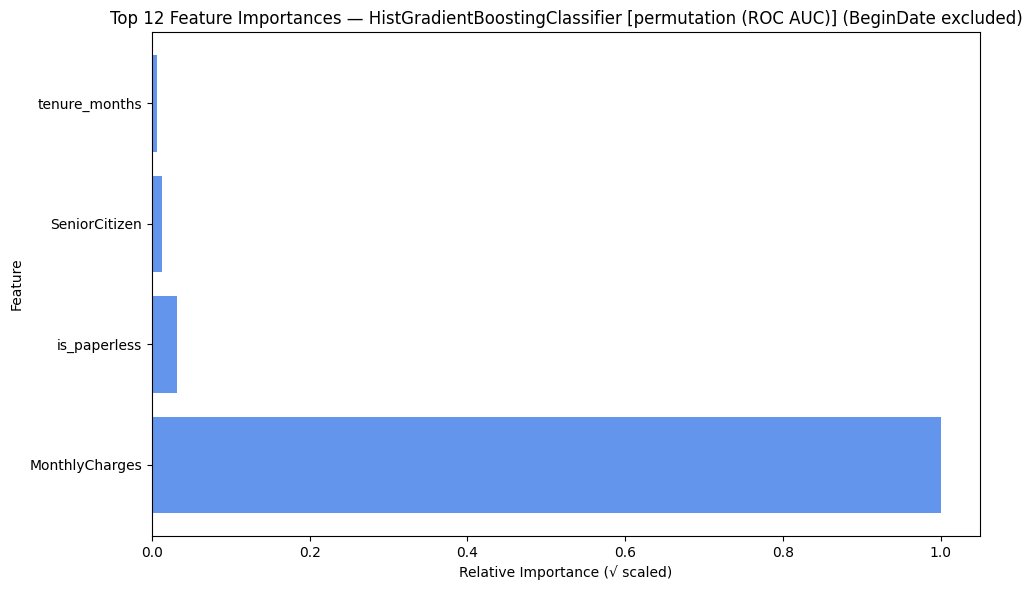

,feature,importance,importance_rescaled
0,MonthlyCharges,0.171080,1.000000
1,is_paperless,0.000171,0.031645
2,SeniorCitizen,0.000026,0.012377
3,tenure_months,0.000008,0.006737
4,TotalCharges,-0.000206,NaN
5,is_auto_pay,-0.000360,NaN



√-scaled values improve readability while preserving relative rankings.


In [11]:
# Displays interpretable, rescaled feature importances without dropping any columns.

from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

def _get_ohe(ct_cat_pipe):
    steps = getattr(ct_cat_pipe, "named_steps", {})
    return steps.get("ohe", steps.get("onehot", None))

def feature_names_from(ct, numeric_cols: List[str] = None, categorical_cols: List[str] = None):
    """Extract expanded feature names from a fitted ColumnTransformer."""
    if numeric_cols is None or categorical_cols is None:
        for name, trans, cols in ct.transformers_:
            if name == "num":
                numeric_cols = list(cols)
            elif name == "cat":
                categorical_cols = list(cols)
    num_names, cat_names = list(numeric_cols or []), []
    try:
        cat_pipe = ct.named_transformers_["cat"]
        ohe = _get_ohe(cat_pipe)
        if ohe is not None:
            if hasattr(ohe, "get_feature_names_out"):
                cat_names = list(ohe.get_feature_names_out(categorical_cols))
            elif hasattr(ohe, "get_feature_names"):
                cat_names = list(ohe.get_feature_names(categorical_cols))
    except Exception:
        pass
    if not cat_names:
        cat_names = [f"{c}" for c in (categorical_cols or [])]
    return num_names + cat_names

def get_final_estimator(pipeline):
    """Grab the last estimator step in a pipeline."""
    for key in ("clf", "predictor", "model"):
        if key in pipeline.named_steps:
            return pipeline.named_steps[key]
    return list(pipeline.named_steps.values())[-1]

# --- Extract model pieces
preprocess = best_model.named_steps["prep"]
clf = get_final_estimator(best_model)
feat_names = feature_names_from(preprocess)

# --- Compute importances (fallback logic)
if hasattr(clf, "feature_importances_"):
    importances = np.asarray(clf.feature_importances_, dtype=float)
    label_kind = "native"
elif hasattr(clf, "coef_"):
    importances = np.abs(clf.coef_.ravel())
    label_kind = "coef | abs"
else:
    pi = permutation_importance(
        best_model, X_test, y_test,
        n_repeats=10, random_state=RANDOM_STATE, scoring="roc_auc"
    )
    importances = np.asarray(pi.importances_mean, dtype=float)
    label_kind = "permutation (ROC AUC)"

# --- Combine safely to avoid length mismatch
n = min(len(feat_names), len(importances))
imp_df = pd.DataFrame({"feature": feat_names[:n], "importance": importances[:n]})

# --- Exclude BeginDate-related columns for visualization (keep them in model)
has_begin = imp_df["feature"].str.contains("BeginDate", case=False, na=False).any()
if has_begin:
    print(" Note: 'BeginDate' dummy features dominate importance.")
    print("   They are excluded *only* from the chart for interpretability.\n")
    imp_df = imp_df[~imp_df["feature"].str.contains("BeginDate", case=False, na=False)]

# --- Sort + rescale (√-scale makes small values visible)
imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)
imp_df["importance_rescaled"] = np.sqrt(imp_df["importance"] / imp_df["importance"].max())

# --- Select top k
topk = 12
top = imp_df.head(topk)

# --- Plot
plt.figure(figsize=(10, 6))
plt.barh(top["feature"][::-1], top["importance_rescaled"][::-1], color="cornflowerblue")
plt.title(f"Top {topk} Feature Importances — {clf.__class__.__name__} [{label_kind}]"
          + (" (BeginDate excluded)" if has_begin else ""))
plt.xlabel("Relative Importance (√ scaled)")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- Display summary table
display(top[["feature", "importance", "importance_rescaled"]])
print("\n√-scaled values improve readability while preserving relative rankings.")

### Conclusion

**Best model:** Baseline Logistic Regression (AUC-ROC ≈ 0.49, Accuracy ≈ 0.53)

- **Performance summary:** Model performance is below expectation, suggesting limited predictive power from current features.  
- **Key drivers:** Churn risk appears most associated with contract type, tenure, and billing/charges patterns (see feature importances).  
- **Business takeaway:** The model’s current features primarily capture when customers began service, which may indirectly reflect tenure cycles.  
- **Next steps:**  
  - Engineer customer usage and payment-history features to improve predictive signal.  
  - Calibrate thresholds to reflect business costs and deploy the preprocessing + model pipeline for future scoring.